# [Insert Creative Title HERE]

## Introduction and Motivation

## Required Libraries

Intro to Pandas:
https://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html

Learning the Spotify API through spotipy:
https://spotipy.readthedocs.io/en/latest/#


In [65]:
import sys
import pandas as pd
import numpy as np
import spotipy
import spotipy.util as util
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition
import plotly.graph_objects as go

## Data Collection and Tidying
//TODO Talk about general authentication flow. Link example resource. Explain how to get the spotify username
//TODO talk about how we chose what columns to keep. Talk about how data is relatively simple and no need to reorganize

In [2]:
print('What music would you like to include in the dataset?')
print()
print('Press 1 for saved/liked tracks')
print('Press 2 for a sample dataset')
print()
choice = int(input("Value: "))

while choice < 1 or choice > 2:
    print()
    print('Not a valid choice XD, try again')
    print()
    choice = int(input('Value: '))

if choice == 1:
    # Generate authorization token for reading user library
    scope = 'user-library-read'
    client_id = 'c3aacebd1b0d4a7ca415ca317ec72531'
    client_secret = '343a5709a346489d9aa013f32f00cfe4'
    redirect_uri = 'http://google.com/'

    print("Please Enter Username")
    username = str(input("Username: ")) #12124976904

    token = util.prompt_for_user_token(username, scope, client_id, client_secret, redirect_uri)

    if token:
        sp = spotipy.Spotify(auth=token)

    else:
        print("Can't get token for", username)
        sys.exit()
    
    def get_saved_tracks():
        results = sp.current_user_saved_tracks()
        tracks = results['items']
        while results['next']:
            results = sp.next(results)
            tracks.extend(results['items'])
        return tracks

    tracks = get_saved_tracks()
    features = []
    for track in tracks:
        features.extend(sp.audio_features(track['track']['uri']))
    features = pd.DataFrame.from_records(features)
    features = features[['acousticness', 'danceability', 'energy', 'instrumentalness', 'tempo', 'valence']]
    features['tempo'] = (features['tempo']-features['tempo'].min())/(features['tempo'].max()-features['tempo'].min())

else:
    features = pd.read_csv('sample_data') #TODO download the dataframe as a csv and add to path
    
features #TODO Add Name and Artist

What music would you like to include in the dataset?

Press 1 for saved/liked tracks
Press 2 for a sample dataset

Value: 1
Please Enter Username
Username: 12124976904


,acousticness,danceability,energy,instrumentalness,tempo,valence
0,0.847000,0.342,0.352,0.899,0.280701,0.0371
1,0.872000,0.318,0.590,0.911,0.404077,0.0317
2,0.815000,0.527,0.332,0.506,0.360837,0.0362
3,0.521000,0.619,0.606,0.541,0.532921,0.4210
4,0.635000,0.544,0.512,0.595,0.471877,0.3600
...,...,...,...,...,...,...
93,0.000018,0.312,0.794,0.361,0.550520,0.4270
94,0.132000,0.536,0.693,0.557,0.477839,0.5360
95,0.000079,0.396,0.760,0.243,0.481419,0.1940
96,0.003340,0.153,0.556,0.880,0.298057,0.0373


## Exploratory Data Analysis & Visualizations

In [ ]:
#Explain the columns and how values are determined.
# Summary Statistics
# Histograms
# Correlation Graphs

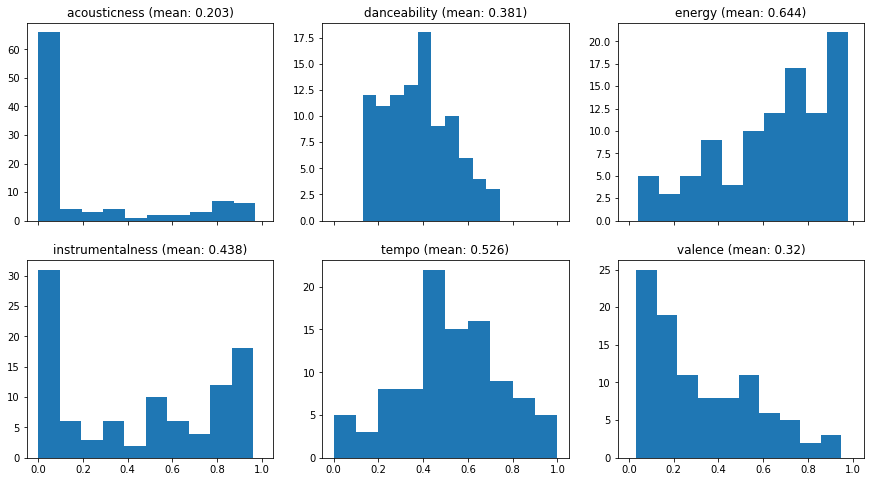

In [3]:
fig, axes = plt.subplots(2, 3, sharex=True, figsize=(15,8))
axes = axes.flatten()
idx = 0

for col in features.columns:
    axes[idx].hist(features[col])
    axes[idx].set_title(col + " (mean: " + str(np.round(features[col].mean(), 3)) + ")")
    idx += 1

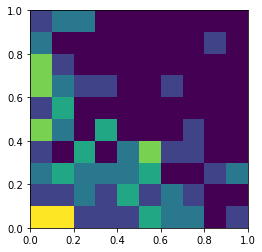

In [4]:
h, xedges, yedges = np.histogram2d(features['energy'], features['valence'])
plt.imshow(h, extent=[0, 1, 0, 1])

## Machine Learning

In [ ]:
# Found cool article on PCA & One Class SVM here:
# https://medium.com/cuepoint/visualizing-hundreds-of-my-favorite-songs-on-spotify-fe50c94b8af3
# Implementation is found here:
# http://www.esparsons.com/blogmain/2018/11/27/an-eclectic-spotify-library-visualized-with-chartify

#TODO PCA Analysis
#TODO One Class SVM
#TODO Clustering

#TODO Error analysis...
#TODO Check if new playlists can fit into the SVM


### Clustering & Principal Component Analysis

In [66]:
clusters = cluster.AffinityPropagation(preference=0).fit(features.values)
pref = 0

while (len(clusters.cluster_centers_) > 10):
    pref -= 1
    clusters = cluster.AffinityPropagation(preference=pref).fit(features.values)
    
cluster_labels = clusters.predict(features)
print("Number of clusters found: " + str(len(clusters.cluster_centers_)))

Number of clusters found: 8


In [68]:
pca = decomposition.PCA(n_components=2)
features_2d = pd.DataFrame(pca.fit_transform(features), columns=['Component 1', 'Component 2'])
features_2d['Cluster'] = cluster_labels
features_2d.head(10)

,Component 1,Component 2,Cluster
0,0.898241,0.086562,3
1,0.794552,-0.000657,3
2,0.639788,0.400949,0
3,0.236736,0.114587,0
4,0.403739,0.159826,0
5,0.764098,0.095522,0
6,0.823118,0.108748,3
7,0.676728,0.140639,0
8,-0.108726,-0.378926,7
9,-0.054590,0.232197,1


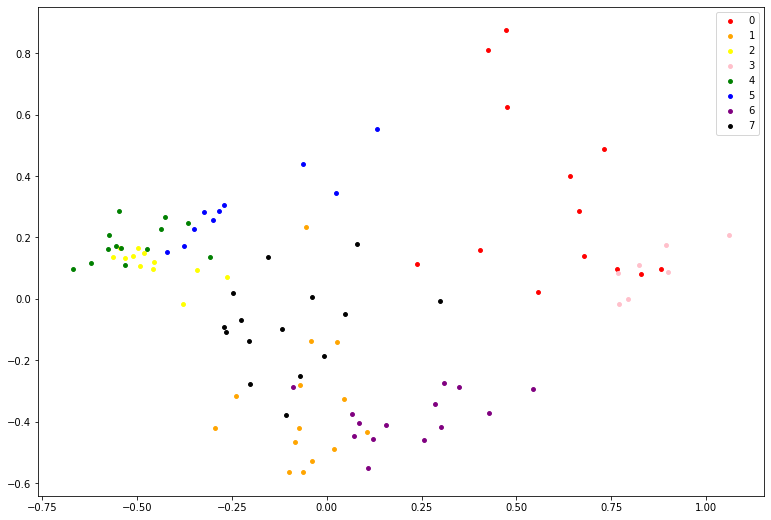

In [79]:
colors = ['red', 'orange', 'yellow', 'pink', 'green', 'blue', 'purple', 'black', 'cyan', 'grey']
fig, ax = plt.subplots(figsize=(13,9))

for cluster_label in features_2d.sort_values('Cluster')['Cluster'].unique():
    group = features_2d.loc[features_2d['Cluster'] == cluster_label]
    ax.scatter(group['Component 1'], group['Component 2'], c = colors[cluster_label], label=cluster_label, s=15)
    
ax.legend()

## Takeaways 